In this notebook, we will reverse engineer the behavior of the L27H29ATN module on dontsay prompts.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import prompt_data, utils, ablation

### Load model

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
# tl_model.requires_grad_(False)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


### Load facts and develop prompt

In [4]:
irrelevant_words = ["apple", "river", "car", "dog", "house", "tree", "book"]

df_raw = pd.read_csv("../../data/facts.csv")
assert set(df_raw.answer) & set(irrelevant_words) == set()
df_raw

,question,answer,type
0,Tom Brady plays the sport of,football,sport
1,LeBron James plays the sport of,basketball,sport
2,Lionel Messi plays the sport of,football,sport
3,Serena Williams plays the sport of,tennis,sport
4,Michael Phelps competes in the sport of,swimming,sport
...,...,...,...
186,Mick Mars plays the,guitar,instrument
187,John Densmore plays the,drums,instrument
188,Jack Bruce plays the,bass,instrument
189,Lars Ulrich plays the,drums,instrument


In [5]:
def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word {forbidden_word}.
<</SYS>>
{question} [/INST] \
"""

df_raw["fb_word"] = "apple"
df_raw["prompt_nc"] = [
    get_dontsay_prompt(q, fw) for q, fw in zip(df_raw.question, df_raw.fb_word)
]
df_raw["prompt_c"] = [
    get_dontsay_prompt(q, answer)
    for q, answer in zip(df_raw.question, df_raw.answer)
]

idx = 0
tl_model.remove_all_hook_fns(including_permanent=True)
for i, prompt in enumerate([df_raw.prompt_nc[idx], df_raw.prompt_c[idx]]):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt, model=tl_model, top_k=5, n_continuation_tokens=20
    )
    print() if i == 0 else None

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 26.48 Prob: 99.67% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 20.00 Prob:  0.15% Tokens: (18322) |FO|OT|B|ALL|</s>|
Rank 2. Logit: 19.85 Prob:  0.13% Tokens: ( 5733) |football|</s>|
Rank 3. Logit: 17.54 Prob:  0.01% Tokens: (13440) |Foot|ball|</s>|
Rank 4. Logit: 17.15 Prob:  0.01% Tokens: (25167) |NFL|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word football.
<</SYS>>
Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 17.79 Prob: 63.15% Tokens: (23185) |Baseball|</s>|
Rank 1. Logit: 16.07 Prob: 11.32% Tokens: (21850) |Basketball|</s>|
Rank 2. Logit: 15.47 Prob:  6.22% Tokens: (  376) |"|B|asketball|"|</s>|
Rank 3. Logit: 15.30 Prob:  5.27% Tokens: (18585) |Sure|!|Tom|Br|ady|plays|...|(|p|aus|es|for|

In [6]:
metrics = []
for idx in tqdm(range(len(df_raw))):
    prompt_nc = df_raw.prompt_nc[idx]
    prompt_c = df_raw.prompt_c[idx]

    with torch.no_grad():
        logits_nc = tl_model.forward(prompt_nc)[0, -1]
        logits_c = tl_model.forward(prompt_c)[0, -1]

    top_tok_nc = logits_nc.argmax().item()
    top_tok_c = logits_c.argmax().item()

    top_tok_nc_prob_nc = logits_nc.softmax(dim=-1)[top_tok_nc]
    top_tok_nc_prob_c = logits_c.softmax(dim=-1)[top_tok_nc]

    log_bf_fb = top_tok_nc_prob_c.logit() - top_tok_nc_prob_nc.logit()

    metrics.append(
        dict(
            top_tok_nc=top_tok_nc,
            top_tok_c=top_tok_c,
            logits_c=logits_c.detach().cpu().numpy(),
            logits_nc=logits_nc.detach().cpu().numpy(),
            top_tok_nc_prob_nc=top_tok_nc_prob_nc.item(),
            top_tok_nc_prob_c=top_tok_nc_prob_c.item(),
            log_bf_fb=log_bf_fb.item(),
            top_str_nc=tl_model.to_string(top_tok_nc),
            top_str_c=tl_model.to_string(top_tok_c),
        )
    )

df_raw = df_raw.assign(**pd.DataFrame(metrics))

  0%|          | 0/191 [00:00<?, ?it/s]

In [7]:
df_raw["correct_nc"] = [
    answer.lower().startswith(top_str_nc.lower())
    for top_str_nc, answer in zip(df_raw.top_str_nc, df_raw.answer)
]
print(f"# correct: {df_raw.correct_nc.sum()} / {len(df_raw)}")
df = df_raw.query("correct_nc").reset_index(drop=True)
df_raw.query("~correct_nc")[["question", "answer", "top_str_nc"]]

# correct: 186 / 191


,question,answer,top_str_nc
128,The element with atomic symbol Kr is,krypton,Pot
134,The element with atomic symbol Pm is,promethium,Pl
170,Chet Baker plays the,trumpet,Jazz
171,Lee Morgan plays the,trumpet,Jazz
188,Jack Bruce plays the,bass,Gu


### Analyze effect of forbidding correct answer

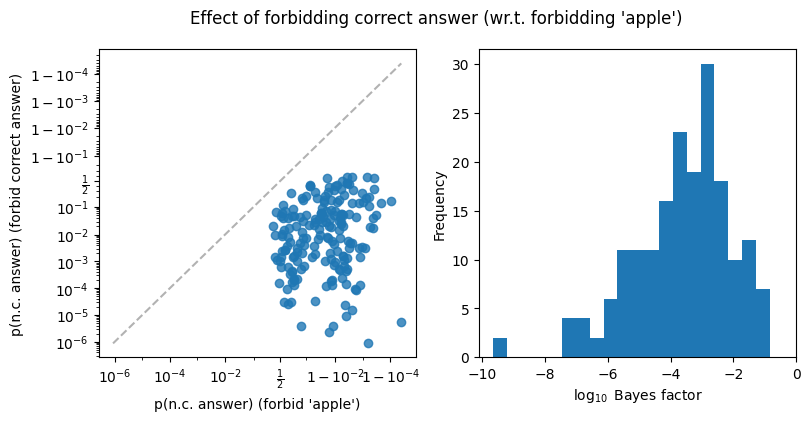

In [8]:
plt.figure(figsize=(9, 4))
plt.suptitle("Effect of forbidding correct answer (wr.t. forbidding 'apple')")

plt.subplot(1, 2, 1)
plt.scatter(df.top_tok_nc_prob_nc, df.top_tok_nc_prob_c, alpha=0.8)
utils.plot_x_eq_y_line(
    df.top_tok_nc_prob_nc,
    df.top_tok_nc_prob_c,
    color="black",
    linestyle="--",
    alpha=0.3,
    zorder=-1,
    label="y=x",
)
plt.xscale("logit")
plt.yscale("logit")
plt.xlabel("p(n.c. answer) (forbid 'apple')")
plt.ylabel("p(n.c. answer) (forbid correct answer)")

plt.subplot(1, 2, 2)
plt.hist(df.log_bf_fb / np.log(10), bins=20)
plt.xlim(right=0)
plt.xlabel("$\log_{10}$ Bayes factor")
plt.ylabel("Frequency")
plt.show()
plt.show()

### Get effect of ablating L27H29

In [9]:
LAYER = 27
HEAD = 29
COMP_STR = f"L{LAYER}H{HEAD}"

In [10]:
metrics = []
for idx in tqdm(range(len(df))):
    prompt_c = df.prompt_c[idx]
    prompt_nc = df.prompt_nc[idx]
    tok = df.top_tok_nc[idx]

    metric_dict = {}
    with torch.no_grad():
        pd_c = prompt_data.PromptData.get_data(prompt_c, tl_model)
        pd_nc = prompt_data.PromptData.get_data(prompt_nc, tl_model)

        for pd_base, pd_patch, base_tag, patch_tag in [
            (pd_c, pd_nc, "c", "nc"),
            (pd_nc, pd_c, "nc", "c"),
        ]:
            res_base = pd_base.cache["resid_post", -1][-1]

            result_base = (
                pd_base.cache["z", LAYER][-1, HEAD] @ tl_model.W_O[LAYER, HEAD]
            )
            result_patch = (
                pd_patch.cache["z", LAYER][-1, HEAD] @ tl_model.W_O[LAYER, HEAD]
            )

            ablt_logits = utils.unembed(
                x=res_base - result_base + result_patch, tl_model=tl_model
            )

            ablt_prob = ablt_logits.softmax(dim=-1)[tok]
            ablt_log_bf = (
                ablt_prob.logit()
                - pd_base.final_logits.softmax(dim=-1)[tok].logit()
            )

            metric_dict |= {
                f"res_{base_tag}": res_base.detach().cpu().numpy(),
                f"result_{base_tag}": result_base.detach().cpu().numpy(),
                f"prob_{base_tag}_{patch_tag}": ablt_prob.item(),
                f"log_bf_{base_tag}_{patch_tag}": ablt_log_bf.item(),
            }

        metrics.append(metric_dict)

df = df.assign(**pd.DataFrame(metrics))

  0%|          | 0/186 [00:00<?, ?it/s]

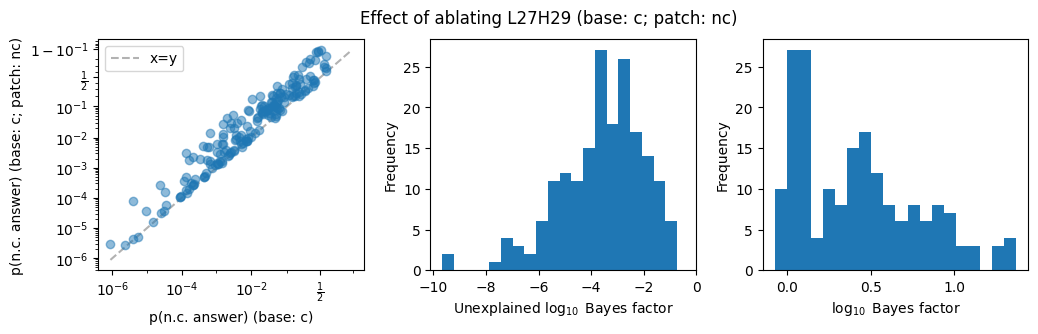

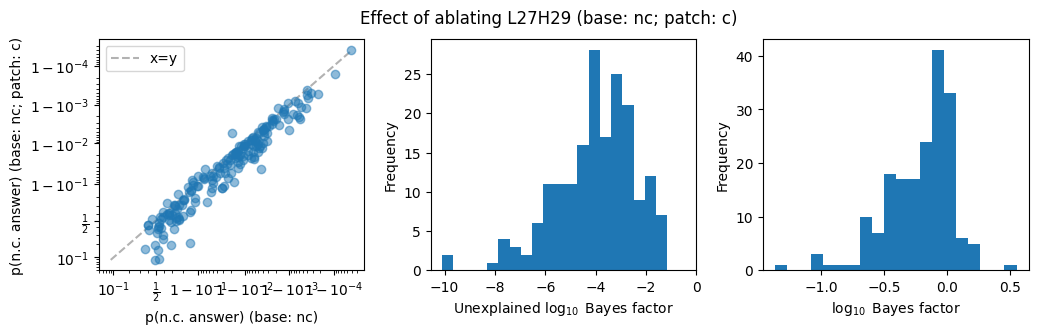

In [11]:
for base_tag, patch_tag in [("c", "nc"), ("nc", "c")]:
    plt.figure(figsize=(12, 3))
    plt.subplots_adjust(wspace=0.25)
    plt.suptitle(f"Effect of ablating {COMP_STR} (base: {base_tag}; patch: {patch_tag})")

    plt.subplot(1, 3, 1)
    plt.scatter(
        df[f"top_tok_nc_prob_{base_tag}"],
        df[f"prob_{base_tag}_{patch_tag}"],
        alpha=0.5,
    )
    utils.plot_x_eq_y_line(
        df[f"top_tok_nc_prob_{base_tag}"],
        df[f"prob_{base_tag}_{patch_tag}"],
        color="black",
        linestyle="--",
        alpha=0.3,
        zorder=-1,
        label="x=y",
    )
    plt.xlabel(f"p(n.c. answer) (base: {base_tag})")
    plt.ylabel(f"p(n.c. answer) (base: {base_tag}; patch: {patch_tag})")
    plt.xscale("logit")
    plt.yscale("logit")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(
        (
            df.log_bf_fb
            + df[f"top_tok_nc_prob_{base_tag}"] * (1 if base_tag == "c" else -1)
        )
        / np.log(10),
        bins=20,
    )
    plt.xlim(right=0)
    plt.xlabel("Unexplained $\log_{10}$ Bayes factor")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 3)
    plt.hist(df[f"log_bf_{base_tag}_{patch_tag}"] / np.log(10), bins=20)
    plt.xlabel("$\log_{10}$ Bayes factor")
    plt.ylabel("Frequency")

    plt.show()

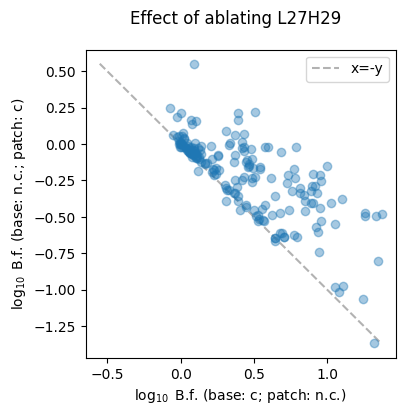

In [12]:
plt.figure(figsize=(4, 4))

plt.scatter(
    df.log_bf_c_nc / np.log(10), df.log_bf_nc_c / np.log(10), alpha=0.4
)
utils.plot_x_eq_y_line(
    df.log_bf_c_nc / np.log(10),
    df.log_bf_nc_c / np.log(10),
    color="black",
    linestyle="--",
    alpha=0.3,
    zorder=-1,
    label="x=-y",
    pos=False,
)
plt.xlabel("$\log_{10}$ B.f. (base: c; patch: n.c.)")
plt.ylabel("$\log_{10}$ B.f. (base: n.c.; patch: c)")
plt.legend()

plt.suptitle(f"Effect of ablating {COMP_STR}")
plt.show()

# Begin reverse engineering

### Start with a single prompt

In [13]:
# Questions on which L27H29 has the biggest effect
df.sort_values("log_bf_c_nc")[["question", "log_bf_c_nc"]].tail()

,question,log_bf_c_nc
173,Jimmy Page plays the,2.894593
94,The Iguazu Falls are in the country of,3.045203
185,Billy Gibbons plays the,3.067379
164,Rory Gallagher plays the,3.109357
182,Mick Mars plays the,3.160057


In [14]:
PROMPT_IDX = 94
PROMPT_NC = df.prompt_nc[PROMPT_IDX]
PROMPT_C = df.prompt_c[PROMPT_IDX]
print(
    f"{COMP_STR} log_10 Bayes factor:",
    df.log_bf_c_nc[PROMPT_IDX] / np.log(10),
)

tl_model.remove_all_hook_fns(including_permanent=True)
for i, prompt in enumerate([PROMPT_NC, PROMPT_C]):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt, model=tl_model, top_k=5, n_continuation_tokens=20
    )
    print() if i == 0 else None

L27H29 log_10 Bayes factor: 1.322514949909482
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
The Iguazu Falls are in the country of [/INST] 
Rank 0. Logit: 23.67 Prob: 85.56% Tokens: (13798) |Argentina|</s>|
Rank 1. Logit: 21.87 Prob: 14.24% Tokens: (16078) |Brazil|</s>|
Rank 2. Logit: 16.58 Prob:  0.07% Tokens: ( 1459) |Par|agu|ay|</s>|
Rank 3. Logit: 15.97 Prob:  0.04% Tokens: ( 9385) |Argent|ine|</s>|
Rank 4. Logit: 15.88 Prob:  0.04% Tokens: (11638) |Brasil|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word Argentina.
<</SYS>>
The Iguazu Falls are in the country of [/INST] 
Rank 0. Logit: 23.34 Prob: 99.72% Tokens: (16078) |Brazil|</s>|
Rank 1. Logit: 16.30 Prob:  0.09% Tokens: (11638) |Brasil|</s>|
Rank 2. Logit: 15.95 Prob:  0.06% Tokens: ( 5032) |Bra|z|ilia|</s>|
Rank 3. Logit: 15.82 Prob:  0.05% To

In [24]:
PD_NC = prompt_data.PromptData.get_data(PROMPT_NC, tl_model)
PD_C = prompt_data.PromptData.get_data(PROMPT_C, tl_model)
CACHE = PD_C.cache
TOKENS = PD_C.tokens
TOKEN_STRS = PD_C.token_strs

WTOK = PD_C.ml_token
FTOK = tl_model.to_single_token("Argentina")
FPOS = 35
assert PD_C.tokens[FPOS].item() == FTOK

WTOK_STR = tl_model.to_string(WTOK)
FTOK_STR = tl_model.to_string(FTOK)
ATTN_SCALE = tl_model.blocks[LAYER].attn.attn_scale

print("Wrong token:", f"|{WTOK_STR}|", WTOK)
print("Forbidden token:", f"|{FTOK_STR}|", FTOK)
print(f"Attention scale for {COMP_STR}:", f"{ATTN_SCALE:.4f}")

Wrong token: |Brazil| 16078
Forbidden token: |Argentina| 13798
Attention scale for L27H29: 11.3137


### Attention pattern

In [27]:
pattern = CACHE["pattern", LAYER][HEAD]
print(f"{COMP_STR} Attention Pattern:")
display(cv_tokens.colored_tokens(["<< bos >>"] + TOKEN_STRS[1:], pattern[-1]))
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + TOKEN_STRS[1:], np.arange(len(TOKEN_STRS))
    )
)

L27H29 Attention Pattern:


### What are all the tokens the head downweights?

Tokens most downweighted by L27H29 (base: c; patch: n.c.):
Argentina (-1.323) AR (-1.156) Argent (-1.131) Arthur (-1.050) Ark (-1.049) 
argent (-0.954) AR (-0.948) argent (-0.910) Arnold (-0.870) arc (-0.841) 
Arc (-0.838) Arn (-0.809) Ar (-0.776) Arena (-0.775) Armen (-0.718) 
Arag (-0.713) Ар (-0.708) arc (-0.707) Arist (-0.689) arga (-0.674) 
ар (-0.662) arrow (-0.643) arrow (-0.627) ark (-0.626) Army (-0.616) 
ар (-0.606) ara (-0.604) agu (-0.600) arct (-0.597) ár (-0.597) 
Inga (-0.588) Ар (-0.580) ars (-0.578) arbitr (-0.574) arch (-0.559) 
camera (-0.548) argo (-0.547) arma (-0.537) Michigan (-0.535) Camera (-0.528) 
egu (-0.527) arbitrary (-0.526) ar (-0.526) arts (-0.521) MongoDB (-0.518) 
ára (-0.512) Arch (-0.511) arks (-0.510) architecture (-0.504) army (-0.503) 


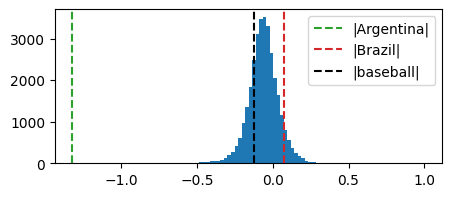

In [28]:
with torch.no_grad():
    logits_c_nc = utils.unembed(
        x=torch.tensor(
            df.res_c[PROMPT_IDX]
            - df.result_c[PROMPT_IDX]
            + df.result_nc[PROMPT_IDX],
            device=utils.device(tl_model),
        ),
        tl_model=tl_model,
    )
    logits_c = torch.tensor(
        df.logits_c[PROMPT_IDX], device=utils.device(tl_model)
    )

    log_bf = -(
        logits_c_nc.softmax(dim=-1).logit() - logits_c.softmax(dim=-1).logit()
    )
    log10_bf = log_bf / np.log(10)

print(f"Tokens most downweighted by {COMP_STR} (base: c; patch: n.c.):")
top_tokens = torch.topk(-log10_bf, 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({log10_bf[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(log10_bf.cpu().numpy(), bins=100)
plt.axvline(
    log10_bf[FTOK].item(),
    color="tab:green",
    linestyle="--",
    label=f"|{FTOK_STR}|",
)
plt.axvline(
    log10_bf[WTOK].item(),
    color="tab:red",
    linestyle="--",
    label=f"|{WTOK_STR}|",
)
plt.axvline(
    log10_bf[tl_model.to_single_token("baseball")].item(),
    color="black",
    linestyle="--",
    label=f"|baseball|",
)
plt.legend()
plt.show()


### OV circuit behavior on forbidden token

In [29]:
E_f = tl_model.W_E[FTOK]
U_f = tl_model.W_U[:, FTOK]
vs = CACHE["v", LAYER][:, HEAD]
attn_pattern = CACHE["pattern", LAYER][HEAD, -1]
result = CACHE["z", LAYER][-1, HEAD] @ tl_model.W_O[LAYER, HEAD]

ln_final = tl_model.ln_final
ln1 = tl_model.blocks[LAYER].ln1
W_V = tl_model.W_V[LAYER, HEAD]
b_V = tl_model.b_V[LAYER, HEAD]
W_O = tl_model.W_O[LAYER, HEAD]


def print_stat(label: str, val: torch.Tensor):
    print(f"{label:<64}: {val.item():.6f}")


def f_log10_prob(x):
    return utils.unembed(x, tl_model).log_softmax(dim=-1)[FTOK] / np.log(10)


print(f"pattern[fpos] = {attn_pattern[FPOS]:.3f}")
print()
print(f"{COMP_STR} stats:")
print_stat("f_log10_prob(result)", f_log10_prob(result))
print_stat(
    "f_log10_odds(pattern @ vs @ W_O)",
    f_log10_prob(attn_pattern @ vs @ W_O),
)
print_stat(
    "f_log10_odds(pattern[fpos] * vs[fpos] @ W_O)",
    f_log10_prob(attn_pattern[FPOS] * vs[FPOS] @ W_O),
)
print()
print_stat(
    "f_log10_odds(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)",
    f_log10_prob(attn_pattern[FPOS] * ln1(E_f) @ W_V @ W_O),
)
print_stat(
    "f_log10_odds(pattern[fpos] * E[fpos] @ W_V @ W_O)",
    f_log10_prob(attn_pattern[FPOS] * E_f @ W_V @ W_O),
)
print()
print_stat(
    "softmax_log10(pattern[fpos] * E[fpos] @ W_V @ W_O @ U)[ftok]",
    (attn_pattern[FPOS] * E_f @ W_V @ W_O @ tl_model.W_U).log_softmax(dim=-1)[
        FTOK
    ]
    / np.log(10),
)
print_stat("log10(1 / d_vocab)", np.log10(1 / tl_model.cfg.d_vocab))

pattern[fpos] = 0.810

L27H29 stats:
f_log10_prob(result)                                            : -19.501049
f_log10_odds(pattern @ vs @ W_O)                                : -19.501049
f_log10_odds(pattern[fpos] * vs[fpos] @ W_O)                    : -19.545954

f_log10_odds(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)          : -16.124332
f_log10_odds(pattern[fpos] * E[fpos] @ W_V @ W_O)               : -15.946536

softmax_log10(pattern[fpos] * E[fpos] @ W_V @ W_O @ U)[ftok]    : -4.541292
log10(1 / d_vocab)                                              : -4.505150


### OV circuit heavior on embedding vectors

tensor(-16.0056, device='cuda:0')
Tokens L27H29 most downweights from raw embedding
China (-24.895) Trump (-22.274) Jordan (-21.829) Washington (-20.685) Amazon (-20.571) 
police (-20.303) monitor (-20.248) techn (-20.246) dynamic (-20.217) Anna (-20.193) 
Apple (-20.116) Bush (-20.090) Chinese (-20.013) Gu (-19.957) George (-19.930) 
Bar (-19.919) DC (-19.894) Technology (-19.880) Science (-19.834) Ford (-19.764) 
Hamilton (-19.720) technology (-19.699) Techn (-19.668) science (-19.627) Jacob (-19.606) 
Indian (-19.590) German (-19.522) Christ (-19.518) MC (-19.480) Jesus (-19.383) 
DJ (-19.363) FM (-19.270) magic (-19.257) Kate (-19.233) Hub (-19.178) 
Facebook (-19.093) God (-19.077) Jord (-19.061) Disney (-19.059) Lincoln (-19.054) 
ABC (-18.883) Microsoft (-18.835) Magic (-18.814) Martin (-18.758) Nelson (-18.741) 
Gu (-18.702) Moon (-18.695) monitoring (-18.680) HD (-18.672) Jones (-18.665) 


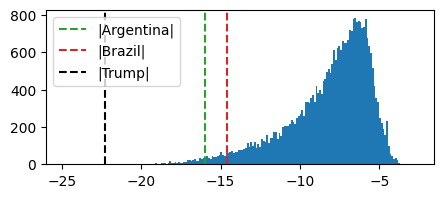

In [30]:
# Very big, 32k x 32k
with torch.no_grad():
    log10_resp_mat = utils.unembed(
        tl_model.W_E @ W_V @ W_O,
        tl_model=tl_model,
    ).log_softmax(dim=-1) / np.log(10)

print(log10_resp_mat[FTOK, FTOK])
print(f"Tokens {COMP_STR} most downweights from raw embedding")
top_tokens = torch.topk(-log10_resp_mat.diag(), 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({log10_resp_mat.diag()[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(log10_resp_mat.diag().cpu().numpy(), bins=200)
plt.axvline(
    log10_resp_mat[FTOK, FTOK].item(),
    color="tab:green",
    linestyle="--",
    label=f"|{FTOK_STR}|",
)
plt.axvline(
    log10_resp_mat[WTOK, WTOK].item(),
    color="tab:red",
    linestyle="--",
    label=f"|{WTOK_STR}|",
)
plt.axvline(
    log10_resp_mat[
        tl_model.to_single_token("Trump"), tl_model.to_single_token("Trump")
    ].item(),
    color="black",
    linestyle="--",
    label=f"|Trump|",
)
plt.legend()
plt.show()

### Forbidden word token enrichment over layers

resid.shape torch.Size([28, 60, 4096])
f_attn_logits.shape torch.Size([28])
ablt_patterns.shape torch.Size([28, 60])
tensor(0.8098, device='cuda:0')


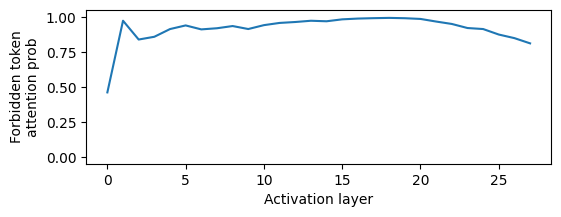

In [32]:
with torch.no_grad():
    rot_q_final = CACHE["rot_q", LAYER][-1, HEAD]

    resid = torch.stack([CACHE["resid_pre", l] for l in range(LAYER + 1)])
    print("resid.shape", resid.shape)
    assert resid.shape == (LAYER + 1, len(TOKENS), tl_model.cfg.d_model)
    assert tl_model.b_K.abs().max() == 0

    resid_norm = tl_model.blocks[LAYER].ln1(resid)
    ks = resid_norm @ tl_model.W_K[LAYER, HEAD]
    ks = einops.rearrange(ks, "layer pos d -> 1 pos layer d")
    rot_ks = tl_model.blocks[LAYER].attn.apply_rotary(ks)
    rot_ks = einops.rearrange(rot_ks, "1 pos layer d -> layer pos d")
    f_rot_ks = rot_ks[:, FPOS]

    f_attn_scores = (f_rot_ks @ rot_q_final) / ATTN_SCALE
    print("f_attn_logits.shape", f_attn_scores.shape)

    ablt_attn_scores = einops.repeat(
        CACHE["attn_scores", LAYER][HEAD, -1],
        "pos -> layer pos",
        layer=len(f_attn_scores),
    ).clone()
    ablt_attn_scores[:, FPOS] = f_attn_scores

    ablt_patterns = ablt_attn_scores.softmax(dim=-1)
    print("ablt_patterns.shape", ablt_patterns.shape)

print(ablt_patterns[:, FPOS][-1])
plt.figure(figsize=(6, 2))
plt.plot(ablt_patterns[:, FPOS].cpu().numpy())
plt.ylim(-0.05, 1.05)
plt.xlabel("Activation layer")
plt.ylabel("Forbidden token\nattention prob")
plt.show()

# cv_attention.attention_pattern(
#     ld.pd.token_strs,
#     ablt_patterns,
#     mask_upper_tri=False,
# )